In [28]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean


%matplotlib inline


In [29]:
# Pobieramy plik z danymi

data = pd.read_csv(r"C:\Users\wojci\OneDrive - SGH\School_\DataScience\Projects\PwC\case.csv", parse_dates=['ds'], index_col='ds')

#data['ds'] = pd.to_datetime(data['ds'])

In [30]:
data.dtypes

INDPRO        float64
MGASUSGULF    float64
GS30          float64
x3            float64
x4            float64
x5              int64
dtype: object

In [31]:
data.head(10)

,INDPRO,MGASUSGULF,GS30,x3,x4,x5
ds,,,,,,
2000-04-01,91.6261,0.695,6.63,1570.9,22.6,115232
2000-05-01,91.9626,0.819,6.23,1852.9,37.9,115573
2000-06-01,92.3118,0.857,6.05,1946.3,19.4,115932
2000-07-01,92.8872,0.732,5.85,2391.2,14.7,116631
2000-08-01,93.1620,0.896,6.15,2209.9,20.9,117295
2000-09-01,93.2168,0.959,5.93,2008.0,12.4,117956
2000-10-01,93.0400,0.829,5.85,2092.8,25.2,118606
2000-11-01,92.7900,0.850,5.72,2023.1,23.0,119275
2000-12-01,93.1547,0.914,5.83,1903.0,31.7,119957


WIZUALIZACJA

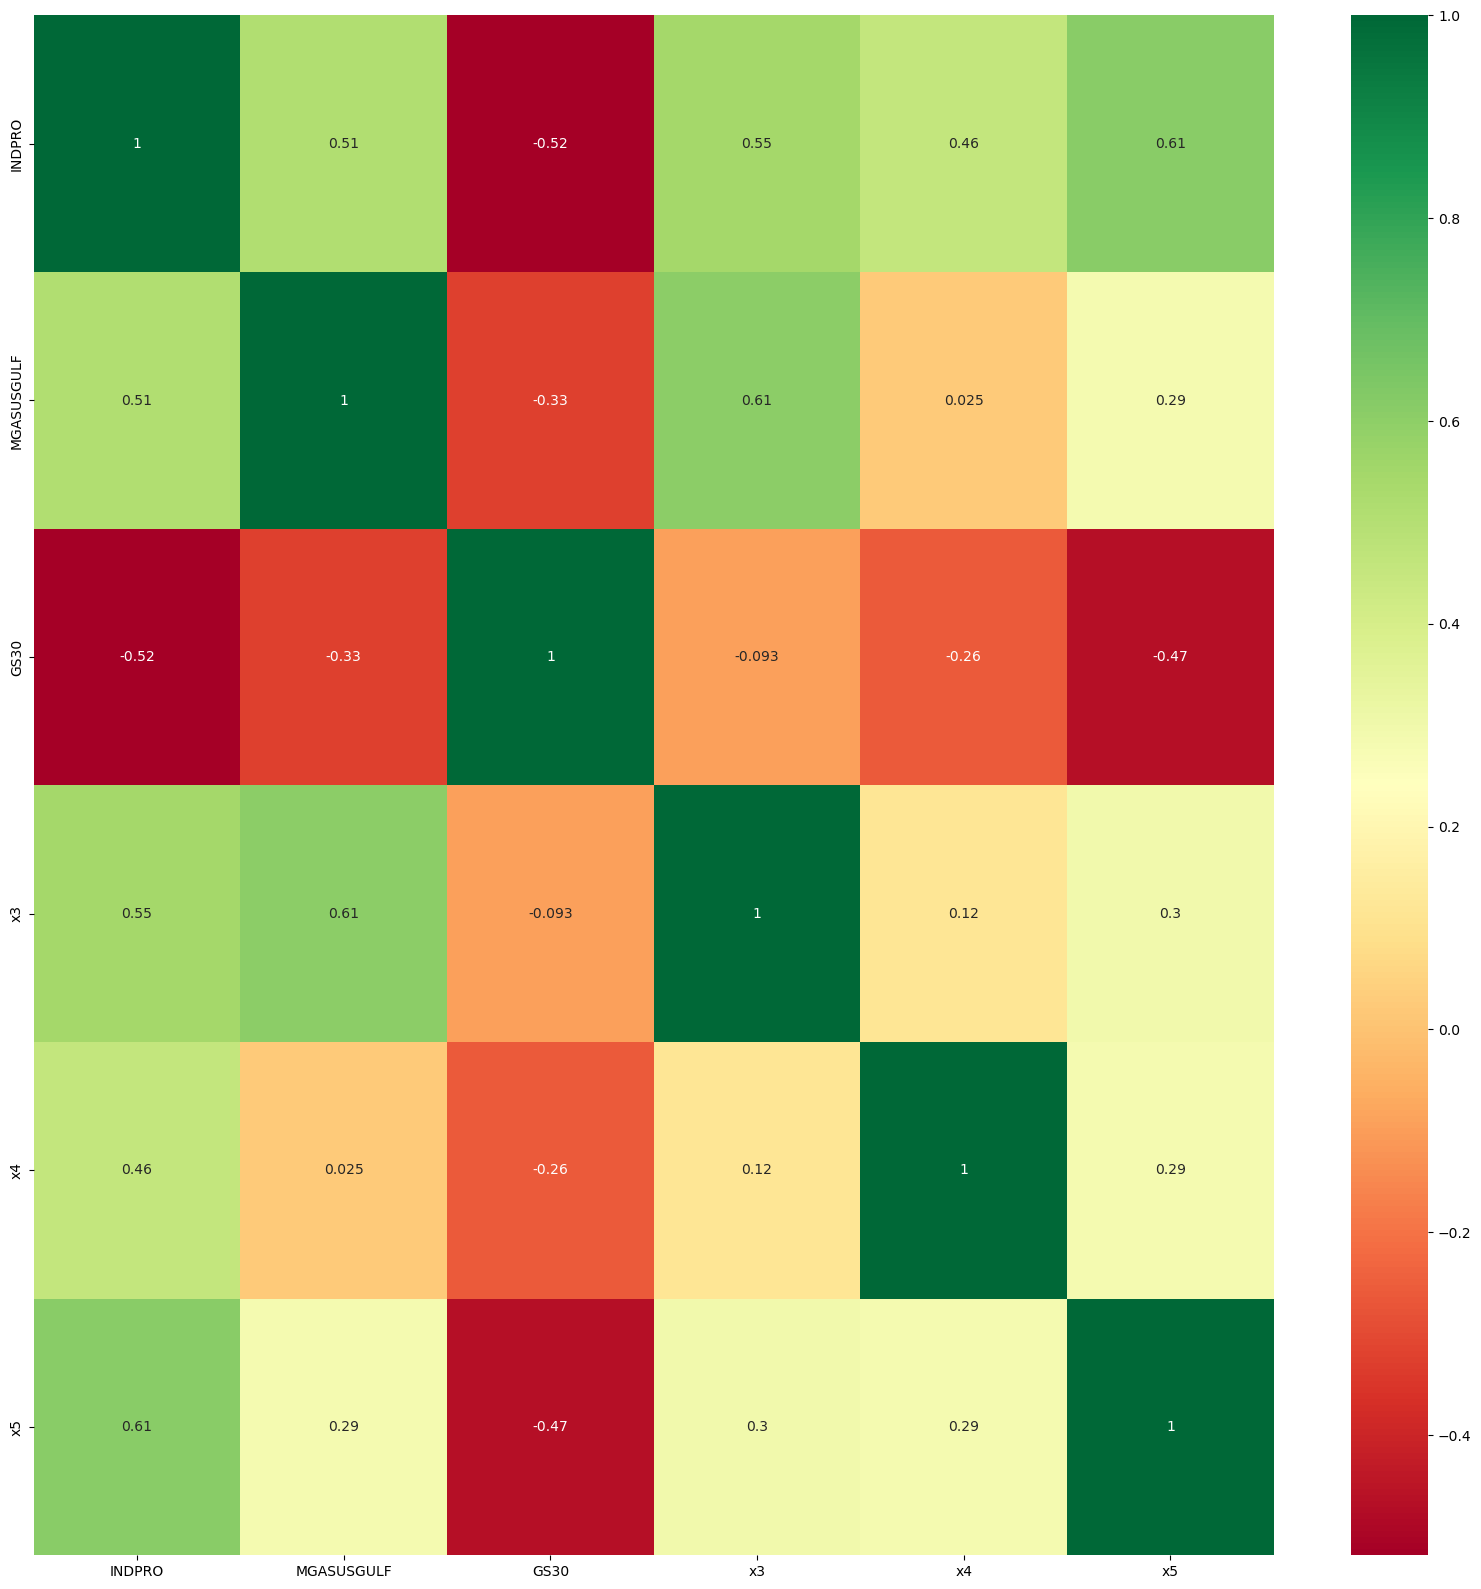

In [32]:
#Get correlations of each features in dataset

corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map

g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

DATA OVERVIEW


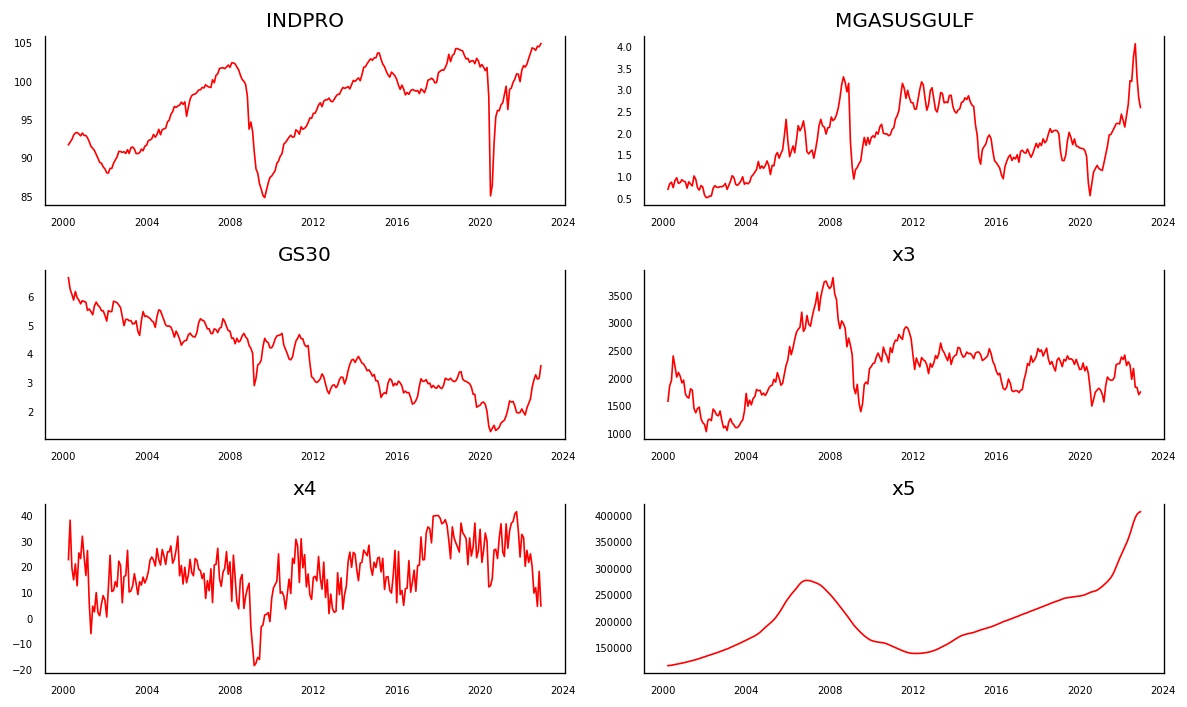

In [33]:
#Plot every variable on the chart

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    
    ax.plot(data[data.columns[i]], color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

#Display the charts

plt.tight_layout();

In [34]:
# select data subset

df1 = data[["INDPRO", "MGASUSGULF","GS30", "x3", "x4","x5"]]
# select data for modeling

x = df1[["MGASUSGULF","GS30", "x3", "x4","x5"]]
y = df1["INDPRO"]

STATIONARITY CHECK

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [36]:
#Do a Dickey-Fuller's test for each variable and check its stationarity

for i in range(len(data.columns)):
    result = adfuller(data[data.columns[i]])

    if result[1] > 0.05:
        print('{} - data is not stationary'.format(data.columns[i]))
        print(f'p value: {result[1]}')
    else:
        print('{} - data is  stationary'.format(data.columns[i]))
        print(f'p value: {result[1]}')


INDPRO - data is not stationary
p value: 0.408505960884209
MGASUSGULF - data is  stationary
p value: 0.02777927324585355
GS30 - data is not stationary
p value: 0.2994520679478384
x3 - data is not stationary
p value: 0.22262641983459336
x4 - data is  stationary
p value: 0.0312114825947241
x5 - data is not stationary
p value: 0.6582804751820961


In [37]:
max_lags=8

#check the p-values in each lag 

for i in range(len(data.columns)-1):
    results = grangercausalitytests(data[['INDPRO', data.columns[i+1]]], max_lags, verbose=False)
    p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(8)]
    print('Column - {} : P_values - {}'.format(data.columns[i+1], p_values))

Column - MGASUSGULF : P_values - [0.0308, 0.0001, 0.0002, 0.0004, 0.0012, 0.0018, 0.0048, 0.0054]
Column - GS30 : P_values - [0.6165, 0.0017, 0.0104, 0.0146, 0.0269, 0.0415, 0.0556, 0.0653]
Column - x3 : P_values - [0.5007, 0.2181, 0.1156, 0.0935, 0.1742, 0.2645, 0.1231, 0.1684]
Column - x4 : P_values - [0.0002, 0.0062, 0.0043, 0.0119, 0.022, 0.041, 0.0523, 0.082]
Column - x5 : P_values - [0.1111, 0.0313, 0.0205, 0.0415, 0.0237, 0.0331, 0.0124, 0.0226]


In [38]:

#Subtract from every present value it last value to make the data stationary

ad_fuller_result_1 = adfuller(data['INDPRO'].diff()[1:])

print('INDPRO')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_1 = adfuller(data['MGASUSGULF'])

print('MGSASUSGULF')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')



ad_fuller_result_1 = adfuller(data['GS30'].diff()[1:])

print('GS30')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')


ad_fuller_result_1 = adfuller(data['x3'].diff()[1:])

print('x3')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')


ad_fuller_result_1 = adfuller(data['x4'].diff()[1:])

print('x4')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')


ad_fuller_result_1 = adfuller(data['x5'].diff()[1:])

print('x5')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')



INDPRO
ADF Statistic: -12.29705467011286
p-value: 7.597261414234209e-23

---------------------

MGSASUSGULF
ADF Statistic: -3.0837512351812895
p-value: 0.02777927324585355
GS30
ADF Statistic: -11.127574367730798
p-value: 3.344259684833202e-20
x3
ADF Statistic: -16.80958672470935
p-value: 1.20205286433166e-29
x4
ADF Statistic: -13.036664103050711
p-value: 2.2857507959372605e-24
x5
ADF Statistic: -2.8100075903439703
p-value: 0.056858413323182894


In [39]:
print('INDPRO causes GS30?\n')
granger_1 = grangercausalitytests(data[['GS30', 'INDPRO']], 4)

print('\n GS30 causes INDPRO?\n')
print('------------------')
granger_2 = grangercausalitytests(data[['GS30', 'INDPRO']], 4)

INDPRO causes GS30?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9993  , p=0.0844  , df_denom=269, df_num=1
ssr based chi2 test:   chi2=3.0328  , p=0.0816  , df=1
likelihood ratio test: chi2=3.0160  , p=0.0824  , df=1
parameter F test:         F=2.9993  , p=0.0844  , df_denom=269, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5786  , p=0.0778  , df_denom=266, df_num=2
ssr based chi2 test:   chi2=5.2541  , p=0.0723  , df=2
likelihood ratio test: chi2=5.2038  , p=0.0741  , df=2
parameter F test:         F=2.5786  , p=0.0778  , df_denom=266, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3790  , p=0.2496  , df_denom=263, df_num=3
ssr based chi2 test:   chi2=4.2472  , p=0.2360  , df=3
likelihood ratio test: chi2=4.2141  , p=0.2393  , df=3
parameter F test:         F=1.3790  , p=0.2496  , df_denom=263, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F

TRAIN & TEST SPLIT

In [40]:

train_df=data[:-12]
test_df=data[-12:]

In [41]:
print(test_df.shape)
print(train_df.shape)

(12, 6)
(261, 6)


HYPERPARAMETER TUNING OF VARMAX MODEL

In [42]:
# Import necessary libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import aic, bic
from joblib import Parallel, delayed

# Define the range of order parameters to test
orders = [(i, j) for i in range(1, 9) for j in range(0, 5)]

# Define a function to fit a VARMAX model for a given order parameter and return the AIC and BIC values
def fit_model(order, train_df):
    try:
        model = VARMAX(train_df, order=order, enforce_stationarity=True)
        fitted_model = model.fit()
        print(order)
        return (order, fitted_model.aic, fitted_model.bic)
    except:
        return None

# Use multiple cores to fit VARMAX models for each order parameter and store the AIC and BIC values
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(fit_model)(order, train_df) for order in orders)

# Remove any `None` values from the results list
results = [result for result in results if result is not None]

# Print the results in a table format
print('{:<8s}{:<8s}{:<8s}'.format('Order', 'AIC', 'BIC'))
for result in results:
    print('{:<8s}{:<8.2f}{:<8.2f}'.format(str(result[0]), result[1], result[2]))

# Select the order parameter with the lowest AIC value
best_aic_order = min(results, key=lambda x: x[1])[0]
print('Best AIC order:', best_aic_order)

# Select the order parameter with the lowest BIC value
best_bic_order = min(results, key=lambda x: x[2])[0]
print('Best BIC order:', best_bic_order)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:  2.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  5.8min remaining:   49.6s


Order   AIC     BIC     
(1, 0)  10184.4510409.02
(1, 1)  10039.9310392.82
(1, 2)  10250.3610731.57
(1, 3)  10807.0811416.62
(1, 4)  10410.6511148.50
(2, 0)  288317.14288670.03
(2, 1)  153381.80153863.01
(2, 2)  529472.59530082.12
(2, 3)  1752735.501753473.35
(2, 4)  75619.7276485.90
(4, 0)  9094.78 9704.31 
(4, 1)  9164.03 9901.89 
(4, 2)  9224.85 10091.03
(4, 3)  9373.95 10368.45
(4, 4)  9310.42 10433.25
(5, 0)  9104.78 9842.64 
(5, 1)  9175.25 10041.43
(5, 2)  9251.26 10245.76
(5, 3)  9335.90 10458.73
(5, 4)  9365.78 10616.93
(6, 0)  9135.54 10001.72
(6, 1)  9219.40 10213.91
(6, 2)  9275.55 10398.37
(6, 3)  61686.7762937.91
(6, 4)  9408.24 10787.71
(7, 0)  9172.94 10167.44
(7, 1)  9245.50 10368.33
(7, 2)  9313.06 10564.20
(7, 4)  9444.05 10951.84
(8, 0)  9192.48 10315.30
(8, 1)  9262.50 10513.64
(8, 2)  9331.30 10710.77
(8, 4)  9462.07 11098.19
Best AIC order: (4, 0)
Best BIC order: (4, 0)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.8min finished


In [43]:
#Tune the order of our model and train it on the train_df set
#Best order is (4,0)

var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit()
print(fitted_model.summary())

                                           Statespace Model Results                                           
Dep. Variable:     ['INDPRO', 'MGASUSGULF', 'GS30', 'x3', 'x4', 'x5']   No. Observations:                  261
Model:                                                         VAR(4)   Log Likelihood               -4376.344
                                                          + intercept   AIC                           9094.688
Date:                                                Sun, 12 Mar 2023   BIC                           9704.221
Time:                                                        23:06:01   HQIC                          9339.701
Sample:                                                    04-01-2000                                         
                                                         - 12-01-2021                                         
Covariance Type:                                                  opg                                         
L

SCORING MODELU

In [44]:
#Creating predictions with the created model

predict = fitted_model.get_prediction(start=1,end=len(data) - 1)

predictions=predict.predicted_mean
     

predictions.columns=['INDPRO_predicted','MGASUSGULF_predicted','GS30_predicted','x3_predicted','x4_predicted','x5_predicted']
predictions

,INDPRO_predicted,MGASUSGULF_predicted,GS30_predicted,x3_predicted,x4_predicted,x5_predicted
2000-05-01,91.867814,0.718002,6.588773,1579.875310,18.893056,116958.464592
2000-06-01,92.335018,0.901206,6.180400,1791.651415,25.342132,115974.196053
2000-07-01,92.455396,0.886574,6.077925,1947.572009,22.646732,116280.761299
2000-08-01,92.710693,0.724340,5.672643,2133.456969,18.688741,117332.396145
2000-09-01,93.470023,1.111463,6.142618,2125.224546,19.366598,118040.399740
...,...,...,...,...,...,...
2022-08-01,107.165076,2.489715,2.098499,3334.235453,37.560236,374561.154200
2022-09-01,107.928853,2.550156,2.109869,3455.426620,38.000515,380875.131662
2022-10-01,108.663600,2.611711,2.120946,3574.617142,38.299861,386916.898534
2022-11-01,109.363805,2.671217,2.128143,3689.308697,38.394038,392659.528578


In [45]:
predicted_values_over_test_df = predictions.tail(12)

In [46]:
#calculate the potential error of the model

rmse=math.sqrt(mean_squared_error(predicted_values_over_test_df['INDPRO_predicted'],test_df['INDPRO']))
mae = mean_absolute_error(predicted_values_over_test_df['INDPRO_predicted'],test_df['INDPRO'])

#Show the error
print('Mean absolute error of y is : {}. \nRoot Mean Squared Error is :{}'.format(round(mae,3),round(rmse,3)))


Mean absolute error of y is : 2.585. 
Root Mean Squared Error is :3.026


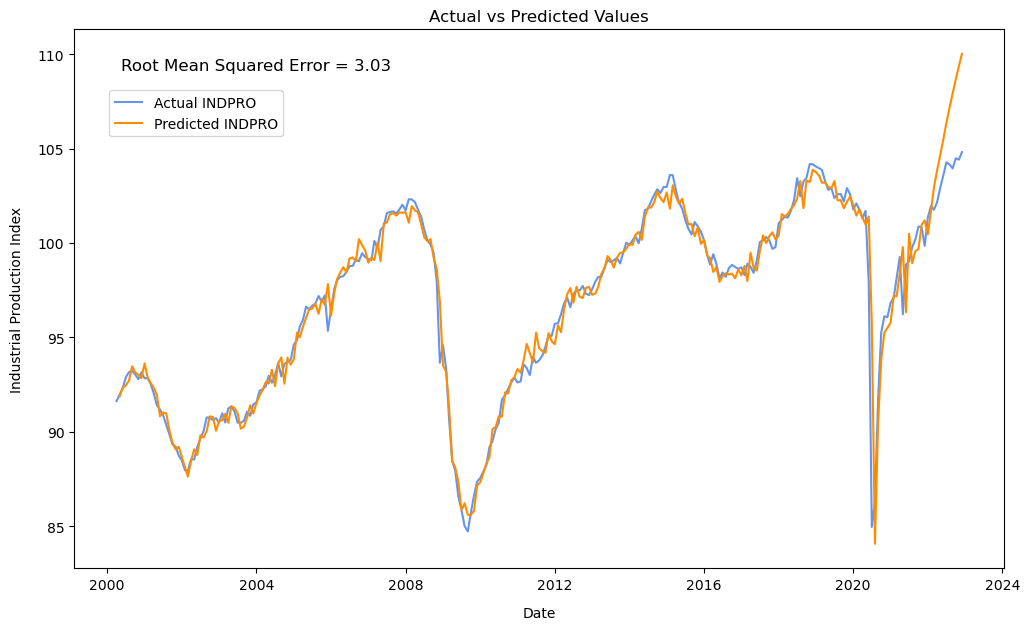

In [47]:
test_vs_pred_INDPRO_test=pd.concat([data['INDPRO'],predictions['INDPRO_predicted']],axis=1)
test_vs_pred_INDPRO_test.rename(columns = {'INDPRO':'actual INDPRO', 'INDPRO_predicted':'predicted INDPRO'}, inplace = True)

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot actual values
ax.plot(test_vs_pred_INDPRO_test.index, test_vs_pred_INDPRO_test['actual INDPRO'], label='Actual INDPRO', color='cornflowerblue')

# Plot predicted values with grey error field
ax.plot(test_vs_pred_INDPRO_test.index, test_vs_pred_INDPRO_test['predicted INDPRO'], label='Predicted INDPRO', color='darkorange')

# Set labels and title
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Industrial Production Index', labelpad=10)
ax.set_title('Actual vs Predicted Values')

# Add legend and text for RMSE
ax.legend(loc='upper left', bbox_to_anchor=(0.03, 0.9))
ax.text(0.05, 0.925, f'Root Mean Squared Error = {rmse:.2f}', transform=ax.transAxes, fontsize=12, color='black')

plt.show()


ACTUAL PREDICTION

In [48]:
#We train the VARMAX model on entire dataset
var_model_future_prediction = VARMAX(data, order=(4,0),enforce_stationarity= True)
fitted_model_future_prediciton = var_model_future_prediction.fit(disp=False)
print(fitted_model_future_prediciton.summary())

                                           Statespace Model Results                                           
Dep. Variable:     ['INDPRO', 'MGASUSGULF', 'GS30', 'x3', 'x4', 'x5']   No. Observations:                  273
Model:                                                         VAR(4)   Log Likelihood               -4677.837
                                                          + intercept   AIC                           9697.675
Date:                                                Sun, 12 Mar 2023   BIC                          10314.895
Time:                                                        23:06:44   HQIC                          9945.439
Sample:                                                    04-01-2000                                         
                                                         - 12-01-2022                                         
Covariance Type:                                                  opg                                         
L

In [49]:
n_forecasts = 4
# Forecasting 4 months ahead using the model trained on the full dataset

predict_future_prediction = fitted_model_future_prediciton.get_prediction(start=1,end=len(data) + n_forecasts - 1)

predictions_future_prediction = predict_future_prediction.predicted_mean
     

predictions_future_prediction.columns=['INDPRO_predicted','MGASUSGULF_predicted','GS30_predicted','x3_predicted','x4_predicted','x5_predicted']
predictions_future_prediction

,INDPRO_predicted,MGASUSGULF_predicted,GS30_predicted,x3_predicted,x4_predicted,x5_predicted
2000-05-01,91.697858,0.690605,6.552646,1613.970637,18.712734,115024.270256
2000-06-01,92.159447,0.852204,6.120957,1827.822961,26.846919,116240.195438
2000-07-01,92.531908,0.840897,6.021122,2020.326376,24.407235,116387.478790
2000-08-01,92.825526,0.721412,5.652831,2227.071010,21.287057,117578.276102
2000-09-01,93.552586,1.077244,6.069384,2208.165634,20.590821,118118.707340
...,...,...,...,...,...,...
2022-12-01,104.744461,2.381675,3.232380,1668.504727,11.667370,405437.123304
2023-01-01,105.325420,2.250971,3.804330,1970.140704,9.873178,405109.856533
2023-02-01,105.075850,1.886256,3.909129,2018.400433,7.011915,403108.579031
2023-03-01,104.419975,1.557089,4.037135,2081.510769,10.024190,399695.819572


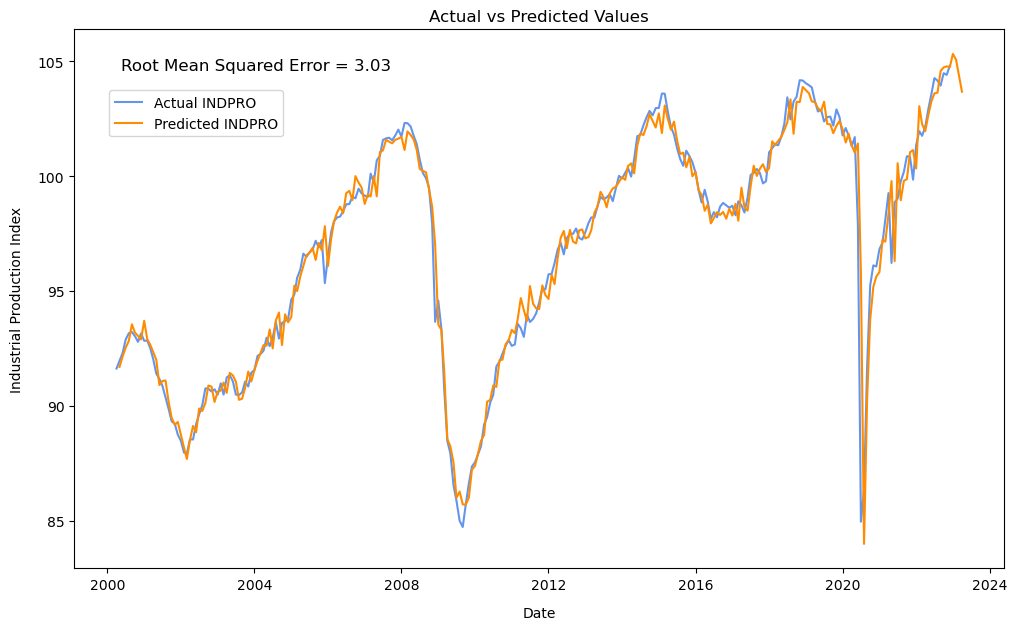

In [50]:
# Building actual forecasting chart showing the predicted vs actual index

test_vs_pred_INDPRO=pd.concat([data['INDPRO'],predictions_future_prediction['INDPRO_predicted']],axis=1)
test_vs_pred_INDPRO.rename(columns = {'INDPRO':'actual INDPRO', 'INDPRO_predicted':'predicted INDPRO'}, inplace = True)

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot actual values
ax.plot(test_vs_pred_INDPRO.index, test_vs_pred_INDPRO['actual INDPRO'], label='Actual INDPRO', color='cornflowerblue')

# Plot predicted values with grey error field
ax.plot(test_vs_pred_INDPRO.index, test_vs_pred_INDPRO['predicted INDPRO'], label='Predicted INDPRO', color='darkorange')

# Set labels and title
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Industrial Production Index', labelpad=10)
ax.set_title('Actual vs Predicted Values')

# Add legend and text for RMSE
ax.legend(loc='upper left', bbox_to_anchor=(0.03, 0.9))
ax.text(0.05, 0.925, f'Root Mean Squared Error = {rmse:.2f}', transform=ax.transAxes, fontsize=12, color='black')

plt.show()


VISUALIZING THE PREDICTION

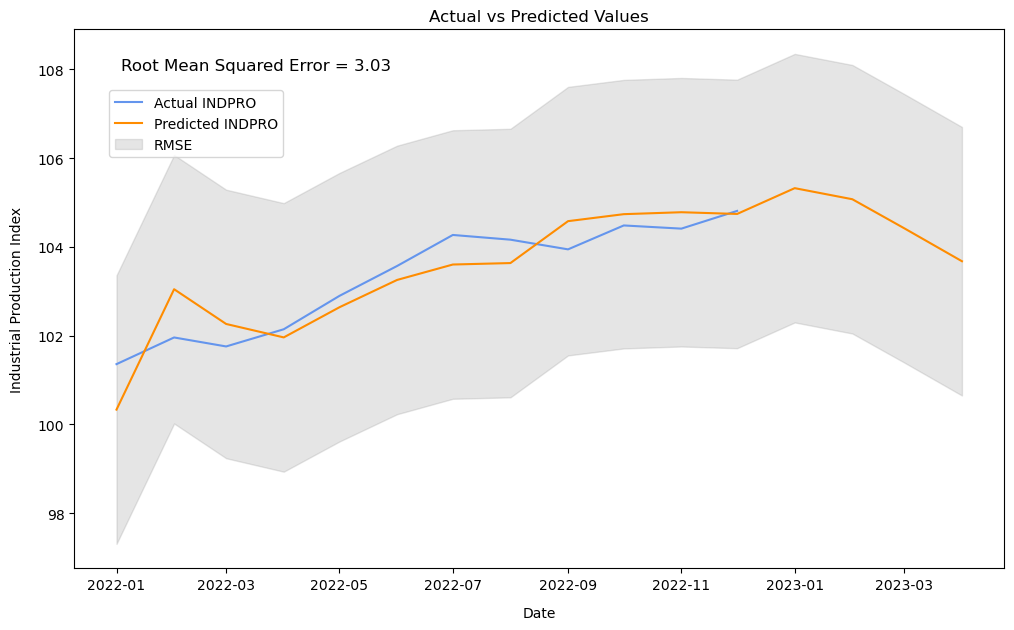

In [51]:
test_vs_pred_INDPRO = pd.concat([data.tail(12)['INDPRO'], predictions_future_prediction.tail(16)['INDPRO_predicted']], axis=1)
test_vs_pred_INDPRO.rename(columns={'INDPRO': 'actual INDPRO', 'INDPRO_predicted': 'predicted INDPRO'}, inplace=True)

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot actual values
ax.plot(test_vs_pred_INDPRO.index, test_vs_pred_INDPRO['actual INDPRO'], label='Actual INDPRO', color='cornflowerblue')

# Plot predicted values with grey error field
ax.plot(test_vs_pred_INDPRO.index, test_vs_pred_INDPRO['predicted INDPRO'], label='Predicted INDPRO', color='darkorange')
ax.fill_between(test_vs_pred_INDPRO.index, test_vs_pred_INDPRO['predicted INDPRO']-rmse, test_vs_pred_INDPRO['predicted INDPRO']+rmse, label='RMSE', alpha=0.2, color='gray')

# Set labels and title
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Industrial Production Index', labelpad=10)
ax.set_title('Actual vs Predicted Values')

# Add legend and text for RMSE
ax.legend(loc='upper left', bbox_to_anchor=(0.03, 0.9))
ax.text(0.05, 0.925, f'Root Mean Squared Error = {rmse:.2f}', transform=ax.transAxes, fontsize=12, color='black')

plt.show()